In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from collections import defaultdict
from pprint import pprint
from Bio import SeqIO
from Bio import Entrez
from matplotlib import cm
import matplotlib.patches as patches

In [2]:
wideform = pd.read_csv('../data/counts/2017-09-28_proportions.csv', index_col=0) ## Each column is a sample

def pivot(df):
    metadata_columns = ['Peptide_sequence', 'start', 'end', 'virus', 'strains']
    sample_columns = [c for c in df.columns.values if c not in metadata_columns]
    records = []
    for idx, row in df.iterrows():
        metadata = row[metadata_columns].to_dict()
        samples = row[sample_columns]
        for sample, value in samples.iteritems():
            record = {'sample': sample, 'value': value}
            record.update(metadata)
            records.append(record)
    new_df = pd.DataFrame(records, columns=['sample', 'value']+metadata_columns)
    return new_df

longform = pivot(wideform) ## Each row is a sample x oligo

In [3]:
metadata_columns = ['Peptide_sequence', 'start', 'end', 'virus', 'strains']
sample_columns = [c for c in wideform.columns.values if c not in metadata_columns]

In [4]:
wideform['specificity'] = wideform[sample_columns].kurtosis(axis=1)
wideform['avg_value'] = wideform[sample_columns].mean(axis=1)

print wideform.columns.values

['NHP-12' 'NHP-8' 'NHP-9' '067-2ng' 'NHP-1' 'NHP-3' 'NHP-5' 'NHP-6'
 'NHP-10' 'NHP-16' 'NHP-17' 'NHP-14' 'NHP-15' '2C6-10ng' '2C6-2ng'
 '067-10ng' 'Peptide_sequence' 'start' 'end' 'virus' 'strains'
 'average-input' 'average-bkgd' 'specificity' 'avg_value']


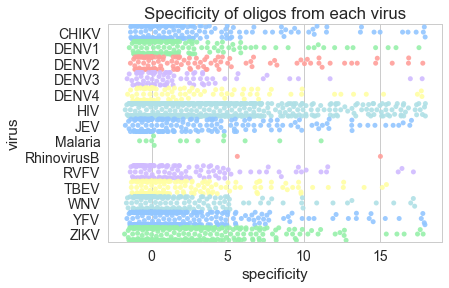

In [5]:
sns.set(style='whitegrid', font_scale=1.4)
ax = sns.swarmplot(x='specificity', y='virus', data=wideform, palette='pastel', alpha=0.9)
ax.set_title('Specificity of oligos from each virus')

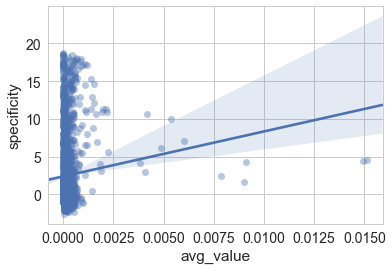

In [6]:
sns.regplot('avg_value', 'specificity', data=wideform, y_jitter=True, scatter_kws={'alpha': 0.4})

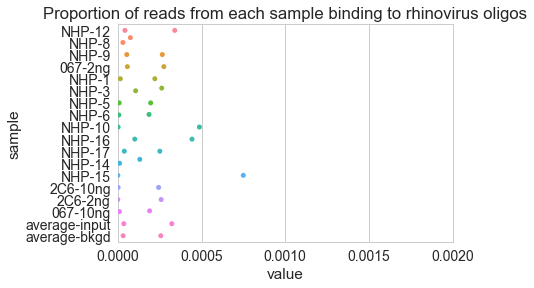

In [7]:
rhinovirus = longform.loc[longform['virus'] == 'RhinovirusB']
ax = sns.swarmplot('value', 'sample', data=rhinovirus)
ax.set_xlim(0,0.002)
ax.set_title('Proportion of reads from each sample binding to rhinovirus oligos')

(0, 0.002)

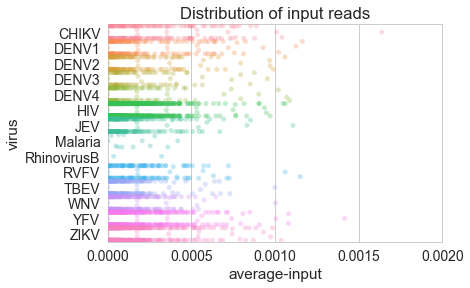

In [8]:
ax = sns.swarmplot('average-input', 'virus', data=wideform, alpha=0.3)
ax.set_title('Distribution of input reads')
ax.set_xlim(0, 0.002)

In [9]:
sample_ids = {
  'NHP-12': 'DENV2', 
#  '2C6-10ng': '', 
 'NHP-10': 'CHIKV', 
 'NHP-16': 'DENV3', 
 'NHP-17': 'ZIKV', 
 'NHP-14': 'DENV1', 
 'NHP-15': 'CONTROL', 
 'average-input': 'CONTROL', 
 'NHP-8': 'ZIKV', 
 'NHP-9': 'DENV4', 
#  '067-2ng': '', 
 'average-bkgd': 'CONTROL', 
 'NHP-1': 'ZIKV', 
#  '2C6-2ng', : ''
 'NHP-3': 'CONTROL', 
#  '067-10ng': '', 
 'NHP-5': 'CONTROL', 
 'NHP-6': 'ZIKV'}

def is_autologous(row):
    if row['sample'] not in sample_ids:
        return np.nan
    sample_id = sample_ids[row['sample']]
    if sample_id == 'CONTROL':
        return 'CONTROL'
    elif sample_id == row['virus']:
        return 'AUTOLOGOUS'
    else:
        return 'HETEROLOGOUS'
    
longform['autologous'] = longform.apply(is_autologous, axis='columns')

In [10]:
specific_longform = pivot(wideform.loc[wideform['specificity'] >= 10.0])

specific_longform['autologous'] = longform.apply(is_autologous, axis='columns')

In [19]:
all_samples = sorted(list(set(longform['sample'].values)))
cmap = cm.Set3
cm_subsection = np.linspace(0, 1,len(all_samples))
colors = [ cmap(i) for i in cm_subsection]
colors = {sample:color for (sample,color) in zip(all_samples, colors)}

sns.set_style(style='whitegrid', rc={'font_scale':1.5})

autologous_colors = {
    'CONTROL': 'lightgray',
    'AUTOLOGOUS': 'lightblue',
    'HETEROLOGOUS': 'purple'
}

def plot_footprints(viruses=None, samples=None, data=longform):
    if viruses == None:
        viruses = set(data['virus'].values)
    if samples == None:
        samples = set(data['sample'].values)
    
    fig, axes = plt.subplots(ncols=1, nrows=len(viruses), figsize=(15, 3*len(viruses)))
    for virus, ax in zip(viruses, axes):
        xmax = 0
        ymax = 0
        for sample in samples:
            subset = data.loc[(data['sample']==sample) & (data['virus'] == virus)]
            
            for idx, oligo in subset.iterrows(): ## Hacky until I decide how I want to do this
                x = oligo['start']
                width = oligo['end'] - oligo['start']
                height = oligo['value']
                if oligo['autologous'] in autologous_colors:
                    color = autologous_colors[oligo['autologous']]
                else:
                    continue
                
                xmax = max([xmax, oligo['end']])
                ymax = max([ymax, oligo['value']])
                
                ax.add_patch(
                patches.Rectangle(
                    (x, 0.),   # (x,y)
                    width,          # width
                    height,          # height
                    alpha=0.35,
                    color=color,
                    edgecolor="none",
                    label=sample
                ))

        ax.set_title(virus)
        ax.set_xlabel('Genomic Position')
        ax.set_ylabel('Proportion of Reads')
        ax.set_xlim(0, xmax)
        ax.set_ylim(0, ymax)
        
#     plt.legend()
    plt.tight_layout()
    plt.show()
    

/Users/Sidney/Library/Python/2.7/lib/python/site-packages/matplotlib/patches.py:121: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


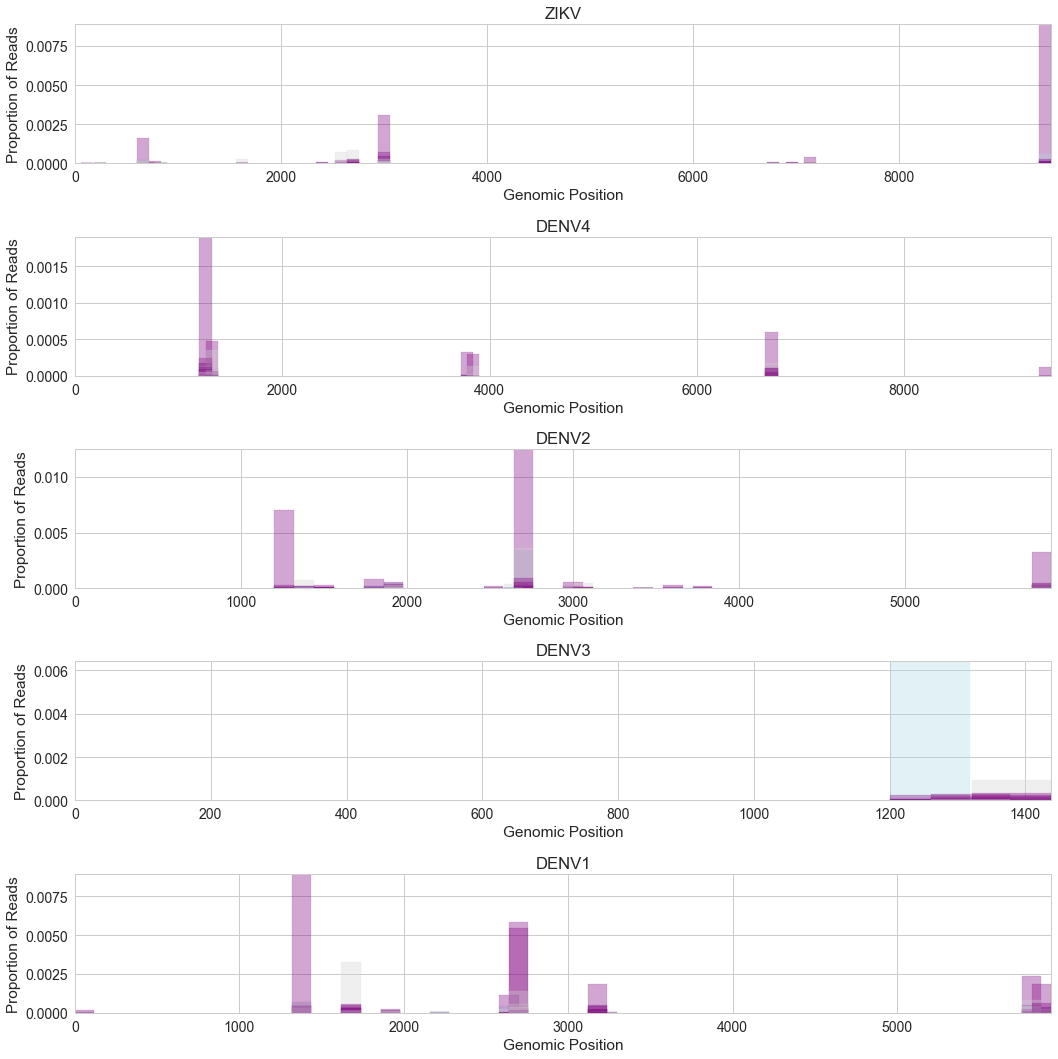

In [21]:
all_viruses = set(specific_longform['virus'].values)
flavis = [v for v in all_viruses if 'ZIK' in v.upper() or 'DEN' in v.upper()]
NHPs = [s for s in all_samples if 'NHP' in s.upper()]

ax = plot_footprints(flavis, NHPs, data=specific_longform)

In [ ]:
sns.swarmplot('value', 'virus', hue='autologous', data=longform, alpha=0.3)

/Users/Sidney/Library/Python/2.7/lib/python/site-packages/matplotlib/patches.py:121: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


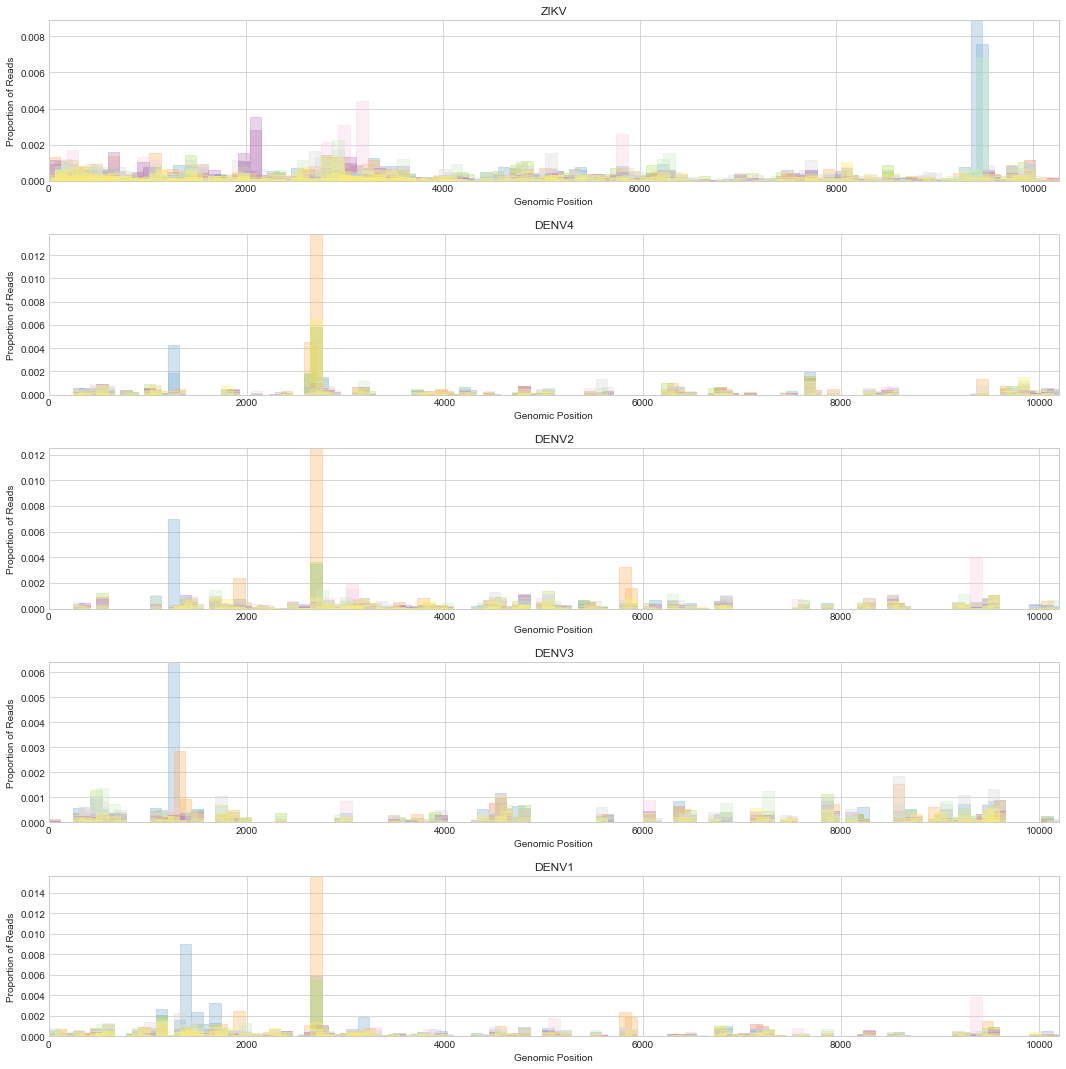

In [5]:
plot_footprints(flavis, NHPs)

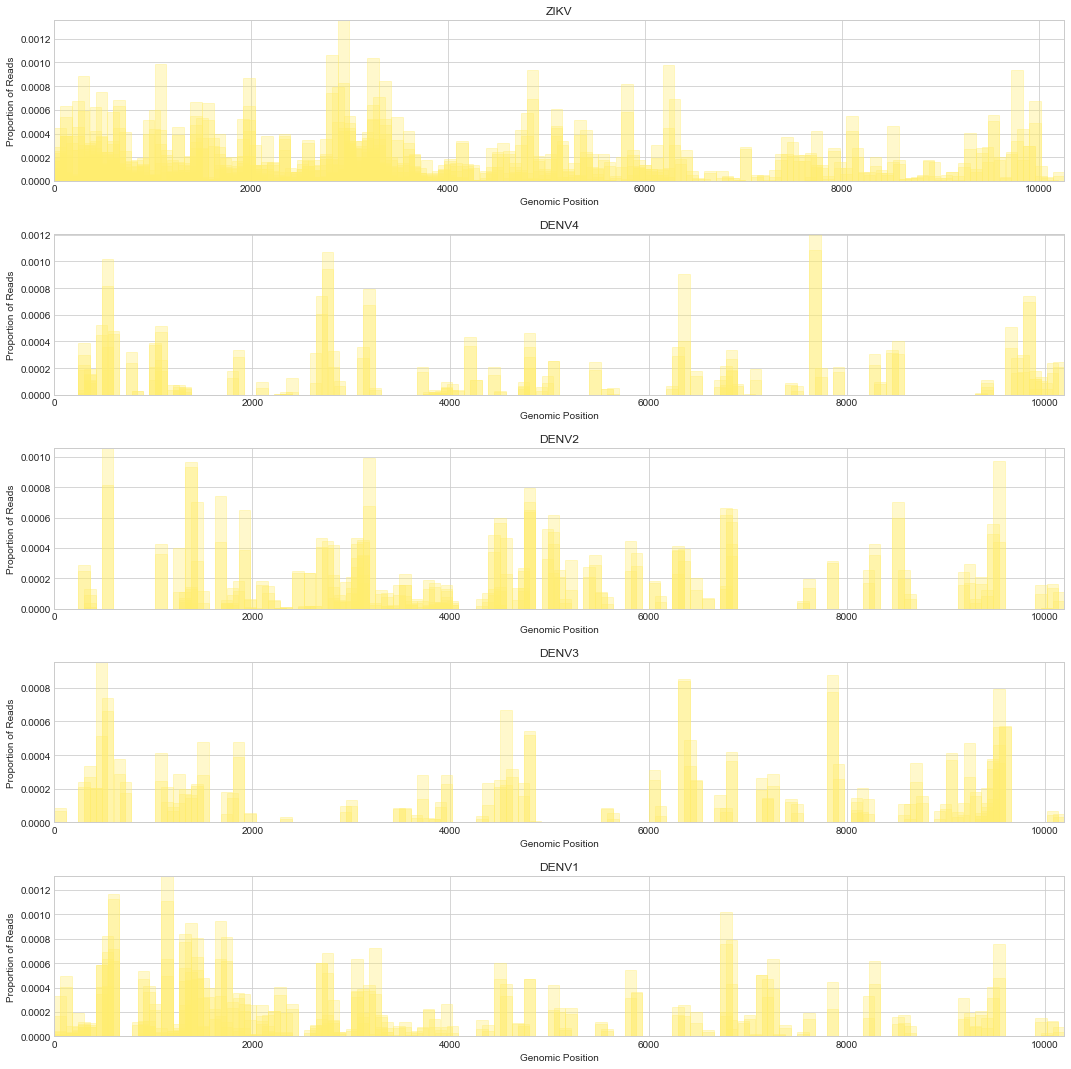

In [18]:
plot_footprints(viruses=flavis, samples=['average-bkgd', 'average-input'])

In [ ]:
''' WIP: eventually add pretty genome maps to the bottom of each virus read plot'''

# ### Parse Reference Accession Numbers from Docs

# reference_df = pd.read_csv('../docs/library_contents_tidy.csv', header=0)
# reference_df.dropna(how='any', inplace=True)

# reference_accessions = defaultdict(list)
# for idx, row in reference_df.iterrows():
#     reference_accessions[row['virus']]+=(row['accession'].split(', '))
# viruses = reference_accessions.keys()

# ### Download reference files from accessions
# def fetch_reference_records(accessions):
#     handle = Entrez.esearch(db="nuccore", term=" ".join(accessions))    # retrieve xml of search results
#     giList = Entrez.read(handle)['IdList'] # pull GI numbers from handle

#     # post NCBI query
#     try:
#         search_handle = Entrez.epost(db="nuccore", id=",".join(giList))
#         search_results = Entrez.read(search_handle)
#         webenv, query_key = search_results["WebEnv"], search_results["QueryKey"]
#         gb_files = Entrez.efetch(db="nuccore", rettype="gb", webenv=webenv, query_key=query_key)
#         seqs = [i for i in SeqIO.parse(gb_files, 'genbank')]
        
#     except RuntimeError:
#         print("ERROR: Couldn't connect with entrez, please run again")
#         print("Accessions:", accessions)
#         print("GIs:", giList)
#         return []
#     return seqs

# references = { virus: fetch_reference_records( reference_accessions[virus]) for virus in viruses}
# print {k: len(v) for k,v in references.items()}

In [3]:
# def parse_ref_map(reference):
#     ''' Parse gene locations from genbank reference files '''
#     gene_map = {}

#     for feature in reference.features:
#         try:
#             gene = feature.qualifiers['product'][0]
#             if gene != 'polyprotein':
#                 gene_map[gene] = (int(feature.location.start), int(feature.location.end))
#         except:
#             continue
#     return gene_map
    
# reference_maps = {virus: parse_ref_map(refs[0]) for virus, refs in references.items() if len(refs)}

In [6]:
print all_viruses

set(['RVFV', 'JEV', 'Malaria', 'HIV', 'ZIKV', 'CHIKV', 'DENV4', 'DENV2', 'DENV3', 'DENV1', 'YFV', 'WNV', 'RhinovirusB', 'TBEV'])
